# Clusterización: Equinox, Accenture and Globant LinkedIn, and Accenture and Globant Articles.

In [1]:
import pandas as pd
import spacy
import string
from langdetect import detect
import re 
import nltk
from nltk.corpus import stopwords
from gensim.models import Phrases
from gensim.corpora import Dictionary
from gensim.models import LdaModel

nlp = spacy.load("en_core_web_lg")

contractions_dict = { "ain\'t": "are not", "\'s":" is", "aren\'t": "are not", "can\'t": "cannot", 
                     "can\'t\'ve": "cannot have", "\'cause": "because", "could\'ve": "could have", 
                     "couldn\'t": "could not", "couldn\'t've": "could not have", "didn\'t": "did not", 
                     "doesn\'t": "does not", "don\'t": "do not", "hadn\'t": "had not", 
                     "hadn\'t\'ve": "had not have", "hasn\'t": "has not", "haven\'t": "have not",
                     "he\'d": "he would", "he\'d\'ve": "he would have", "he\'ll": "he will", 
                     "he\'ll\'ve": "he will have", "how\'d": "how did", "how\'d\'y": "how do you", 
                     "how\'ll": "how will", "i\'d": "i would", "i\'d\'ve": "i would have", "i\'ll": "i will",
                     "i\'ll\'ve": "i will have", "i\'m": "i am", "i\'ve": "i have", "isn\'t": "is not",
                     "it\'d": "it would", "it\'d\'ve": "it would have", "it\'ll": "it will", 
                     "it\'ll\'ve": "it will have", "let\'s": "let us", "ma\'am": "madam", "mayn\'t": "may not",
                     "might\'ve": "might have", "mightn\'t": "might not", "mightn\'t\'ve": "might not have",
                     "must\'ve": "must have", "mustn\'t": "must not", "mustn\'t\'ve": "must not have",
                     "needn\'t": "need not", "needn\'t\'ve": "need not have", "o\'clock": "of the clock",
                     "oughtn\'t": "ought not", "oughtn\'t\'ve": "ought not have", "shan\'t": "shall not",
                     "sha\'n\'t": "shall not", "shan\'t\'ve": "shall not have", "she\'d": "she would",
                     "she\'d\'ve": "she would have", "she\'ll": "she will", "she\'ll\'ve": "she will have", 
                     "should\'ve": "should have", "shouldn\'t": "should not", "shouldn\'t\'ve": "should not have",
                     "so\'ve": "so have", "that\'d": "that would", "that\'d\'ve": "that would have",
                     "there\'d": "there would", "there\'d\'ve": "there would have", "they\'d": "they would",
                     "they\'d\'ve": "they would have","they\'ll": "they will", "they\'ll\'ve": "they will have",
                     "they\'re": "they are", "they\'ve": "they have", "to\'ve": "to have", "wasn\'t": "was not",
                     "we\'d": "we would", "we\'d\'ve": "we would have", "we\'ll": "we will", "we\'ll\'ve": "we will have",
                     "we\'re": "we are", "we\'ve": "we have", "weren\'t": "were not","what\'ll": "what will",
                     "what\'ll've": "what will have", "what\'re": "what are", "what\'ve": "what have",
                     "when\'ve": "when have", "where\'d": "where did", "where\'ve": "where have", 
                     "who\'ll": "who will", "who\'ll\'ve": "who will have", "who\'ve": "who have",
                     "why\'ve": "why have", "will\'ve": "will have", "won\'t": "will not",
                     "won\'t\'ve": "will not have", "would\'ve": "would have", "wouldn\'t": "would not",
                     "wouldn\'t\'ve": "would not have", "y\'all": "you all", "y\'all\'d": "you all would",
                     "y\'all\'d'\'ve": "you all would have", "y\'all\'re": "you all are",
                     "y\'all\'ve": "you all have", "you\'d": "you would", "you\'d\'ve": "you would have",
                     "you\'ll": "you will", "you\'ll\'ve": "you will have", "you\'re": "you are",
                     "you\'ve": "you have"}


def expand_contractions(s, contractions_dict=contractions_dict):
  contractions_re = re.compile('(%s)'%'|'.join(contractions_dict.keys()))
  def replace(match):
    return contractions_dict[match.group(0)]
  return contractions_re.sub(replace, s)


def clean_hashtag_url(post):
    """
    remove all hastags and website links from a string
    """    

    return " ".join(word for word in post.split(' ') if ("#" not in word and "http" not in word))

def punct_space(token):
    """
    helper function to eliminate tokens
    that are pure punctuation or whitespace
    """

    return token.is_punct or token.is_space

def rm_pattern(post):
    """
    function returning a string without "...see more" and website links from the post. 
    This function uses "re.sub" to remove a specific pattern"""

    post = re.sub("…see more",'', post) # replace pattern by an empty string
    post = re.sub('http','',post)
    return post

def preprocess(post):
    
    clean_text = post.translate(str.maketrans("", "", string.punctuation))
    clean_text = clean_text.replace("\n", " ")
    clean_text = clean_text.replace("\u200d", "")
    clean_text = clean_text.replace("\u200b", "")
    clean_text = clean_text.replace("▪", "")
    clean_text = clean_text.replace("Equinox", "")
    clean_text = clean_text.replace("equinox", "")
    clean_text = clean_text.replace("\'", "")
    clean_text = clean_text.replace("”", "")
    clean_text = clean_text.lower()
    stop_words = set(stopwords.words('english'))# - {'we', 'i', 'you', 'our', 'himself', 'herself', 'him', 'hers', 'his', 'her', 'ourselves', 'themselves', 'ours'}
    clean_text = " ".join([word for word in clean_text.split() if word not in stop_words])
    clean_text = " ".join(clean_text.split())
    
    return clean_text

def rules(token):
    """
    conditions to select a specific token for the corpus cleaning
    used with all() function : return True if all True.
    Conditions are : no pure puncuation - no pure whitespace - not a stopword 
    - not a #word
    """

    return [not punct_space(token),
            token.pos_ == 'NOUN' or token.pos_ =="ADJ"] 

def corpus_cleaning(posts):
    """
    generator function using spaCy to parse posts,
    remove "...see more" pattern, website links, lemmatize the text, lowercase words, and apply all the conditions we have set in rules.
    What this function returns is a generator (a "list") of individual tokens contained in lists. 
    """
    
    for post in nlp.pipe(posts.apply(rm_pattern)):
        yield ' '.join([token.lemma_ for token in post if all(rules(token))])

def main_token(json_name,column_name_corpus):

    nltk.download('stopwords')
    df = pd.read_json(json_name)

    df['language'] = df[column_name_corpus].apply(detect)
    df=df[df['language']!= 'es'].drop('language', axis=1)

    corpus=df[column_name_corpus]

    corpus = corpus.apply(expand_contractions)

    corpus = corpus.apply(clean_hashtag_url)
    corpus = corpus.apply(preprocess)

    preprocessed_posts = corpus_cleaning(corpus)
    streamed_posts = (post.split(' ') for post in preprocessed_posts)
    all_posts = []
    for streamed_post in streamed_posts:
        post = ' '.join(streamed_post)
        all_posts.append(post)

    # Process after cleaning

    df['descripcion_clean'] = all_posts

    preprocessed_posts = corpus_cleaning(corpus)
    streamed_posts = (post.split(' ') for post in preprocessed_posts)
    bigram_model = Phrases(streamed_posts,min_count=5,threshold=10)

    bigram_posts = []

    preprocessed_posts = corpus_cleaning(corpus)
    streamed_posts = (post.split(' ') for post in preprocessed_posts)

    for streamed_post in streamed_posts:
        bigram_post = ' '.join(bigram_model[streamed_post])
        bigram_posts.append(bigram_post)

    clean_corpus=bigram_posts

    return clean_corpus
    

if __name__ == "__main__":
    clean_corpus=main_token("equinox_linkedin.json","descripcion")
    print(clean_corpus)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ynino\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['trend intelligence ️rpawhich implement business', 'want share trend future year', 'method aid mathematician new amazing thing field', 'imagination programmer', 'indoor garden app fresh vegetable day plant green mashable', 'way wildlifeconservation vast datum collection study protect specie 🐨 track wildlife pattern prediction specie 🐼 animal specie', 'participant semilla apprenticeship talk experience last month today thank effort welcome team 🏻 👏 🏻 👏', 'today new member team semilla plan apprenticeship help professional first job undergraduate program honor opportunity last month mentor possible tooalejandro salamanca', 'answer question thought world', 'second day 📲 key ️multidisciplinary team boost designer datum_scientist engineer design key product good design invisible notorious bad design', 'shocking truth datum_science career datum sciencist build model', 'good solution context need accurate use ml', 'webinar balance human talksoscar raúl garavito lab image tourism website', 'n

### Frecuencia de las palabras

In [2]:
import collections
import re

# Unimos todos los strings del corpus en uno solo
corpus = ' '.join(clean_corpus)
palabras = re.findall(r'\b\w+\b', corpus)

# Contamos la frecuencia de cada palabra y las ordenamos por frecuencia descendente
frecuencia_palabras = collections.Counter(palabras).most_common()

print(frecuencia_palabras)

# Calculamos el número total de palabras en el corpus
num_palabras = len(palabras)

# Creamos un diccionario con la frecuencia de cada palabra y su porcentaje en relación al número total de palabras
frecuencia_porcentaje = {palabra: (frecuencia/num_palabras)*100 for palabra, frecuencia in frecuencia_palabras}

# Imprimimos el diccionario ordenado por frecuencia descendente
for palabra, frecuencia in sorted(frecuencia_porcentaje.items(), key=lambda item: item[1], reverse=True):
    print(palabra, ": ", round(frecuencia, 2), "%")

[('technology', 42), ('human', 40), ('new', 37), ('team', 37), ('machine', 37), ('year', 36), ('datum', 36), ('business', 34), ('design', 33), ('today', 32), ('quantum', 31), ('robot', 29), ('day', 28), ('model', 28), ('work', 28), ('solution', 27), ('designer', 26), ('good', 26), ('article', 24), ('experience', 23), ('time', 23), ('artificial_intelligence', 23), ('way', 22), ('company', 22), ('people', 21), ('lab', 20), ('user', 20), ('information', 20), ('process', 20), ('job', 18), ('industry', 18), ('woman', 18), ('course', 18), ('week', 17), ('engineer', 16), ('video', 16), ('data', 16), ('last', 15), ('different', 15), ('automation', 15), ('future', 14), ('thank', 14), ('knowledge', 14), ('fact', 14), ('happy', 14), ('class', 14), ('talk', 13), ('first', 13), ('application', 13), ('help', 12), ('world', 12), ('datum_scientist', 12), ('many', 12), ('project', 12), ('daily', 12), ('plan', 11), ('use', 11), ('image', 11), ('science', 11), ('next', 11), ('love', 11), ('computer', 11)

### LDA

In [3]:
from gensim.corpora import Dictionary
posts = pd.Series(clean_corpus)

# Dictionary recquired to split the sentences into a list of words. Let's use split() function
streamed_posts = posts.apply(lambda str : str.split())

# Then we learn the dictionary by iterating over all of the reviews
# It return a generator
posts_dictionary = Dictionary(streamed_posts)

In [4]:
posts_dictionary.filter_extremes(no_below=10, no_above=0.5)
posts_dictionary.compactify()

bag_of_words = [posts_dictionary.doc2bow(post) for post in streamed_posts]

In [5]:
from gensim.models import LdaModel

num_topics = 5

# Train the model on the corpus.
lda = LdaModel(corpus=bag_of_words, id2word=posts_dictionary, num_topics=num_topics, passes=20,
                iterations=1000, random_state=100)

In [6]:
def explore_topic(topic_number, topn=25):
    """
    accept a user-supplied topic number and
    print out a formatted list of the top terms
    """
        
    print ('{:20}{}'.format('term', 'frequency'))

    for term, frequency in lda.show_topic(topic_number,topn):
        print ("{:20}{:.03f}".format(term, round(frequency, 3)))

In [7]:
explore_topic(0, topn=5)

term                frequency
day                 0.094
course              0.074
article             0.073
new                 0.068
today               0.060


In [8]:
explore_topic(1, topn=5)

term                frequency
designer            0.095
good                0.093
solution            0.071
️                   0.063
design              0.060


In [9]:
explore_topic(2, topn=5)

term                frequency
robot               0.091
technology          0.083
business            0.065
quantum             0.061
process             0.046


In [10]:
explore_topic(3, topn=5)

term                frequency
datum               0.129
user                0.051
year                0.048
woman               0.046
industry            0.044


In [11]:
explore_topic(4, topn=5)

term                frequency
machine             0.096
human               0.076
team                0.073
time                0.071
way                 0.046


In [12]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

LDAvis_prepared = gensimvis.prepare(lda, bag_of_words,
                                              posts_dictionary)
pyLDAvis.display(LDAvis_prepared)

c:\Users\ynino\AppData\Local\anaconda3\envs\PLANSEMILLA\Lib\site-packages\pyLDAvis\_prepare.py:244: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  by='saliency', ascending=False).head(R).drop('saliency', 1)


### K-Means

In [43]:
from sklearn.feature_extraction.text import TfidfVectorizer

#Ignore terms that appear in more than 50% of the documents (max_df=0.5) and terms that are not present in at least 5 documents (min_df=5)
vectorizer = TfidfVectorizer(stop_words="english", max_df=0.5, min_df=1, sublinear_tf=True)


equinox_linkedin_matrix = vectorizer.fit_transform(clean_corpus)

print(f"n_samples: {equinox_linkedin_matrix.shape[0]}, n_features: {equinox_linkedin_matrix.shape[1]}")


n_samples: 266, n_features: 1305


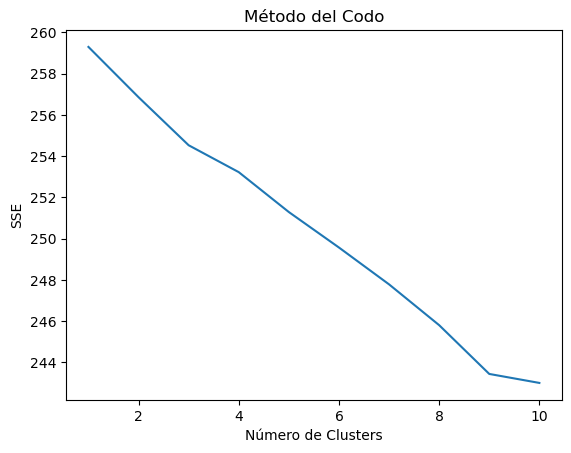

In [44]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings('ignore')


# Calcular el valor de SSE para diferentes valores de k
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(equinox_linkedin_matrix)
    sse.append(kmeans.inertia_)

# Graficar la curva SSE vs. k
plt.plot(range(1, 11), sse)
plt.title('Método del Codo')
plt.xlabel('Número de Clusters')
plt.ylabel('SSE')
plt.show()

In [45]:
# Aplicar el algoritmo K-Means a la matriz de características
kmeans = KMeans(n_clusters=9, random_state=0)
kmeans.fit(equinox_linkedin_matrix)

# Obtener los clusters asignados a cada documento
clusters = kmeans.labels_

# Obtener las palabras más comunes de cada cluster
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names_out()
for i in range(9):
    print("Cluster %d:" % i),
    for j in order_centroids[i, :5]:
        print(' %s' % terms[j]),
    print('\n')

Cluster 0:
 different
 team
 love
 professional
 perspective


Cluster 1:
 happy
 year
 day
 community
 thank


Cluster 2:
 model
 datum_scientist
 user
 video
 apply


Cluster 3:
 robot
 article
 human
 conflict
 summary


Cluster 4:
 datum
 data
 datum_science
 implementation
 information


Cluster 5:
 quantum
 course
 website
 quantum_computing
 technology


Cluster 6:
 today
 woman
 technology
 science
 artificial_intelligence


Cluster 7:
 business
 good
 solution
 process
 future


Cluster 8:
 talk
 event
 lab
 holistic_design
 experience




Cluster 0: Este cluster parece estar relacionado con el ámbito profesional, la perspectiva y los equipos de trabajo.
 
Cluster 1: Este cluster podría estar relacionado con la gratitud, el agradecimiento, las comunidades y las celebraciones.

Cluster 2: Este cluster está relacionado con el mundo de los datos, el análisis de datos y la ciencia de datos.

Cluster 3: Este cluster parece estar relacionado con la tecnología y la inteligencia artificial, específicamente con robots y humanos.

Cluster 4: Este cluster está relacionado con la ciencia de datos, la información y la implementación de datos.

Cluster 5: Este cluster parece estar relacionado con la tecnología emergente, específicamente con la informática cuántica y los cursos relacionados con ella.

Cluster 6: Este cluster podría estar relacionado con las mujeres en ciencia y tecnología, así como con la inteligencia artificial y la ciencia en general.

Cluster 7: Este cluster está relacionado con el mundo de los negocios y las soluciones empresariales.

Cluster 8: Este cluster podría estar relacionado con la experiencia del usuario, el diseño holístico y los eventos y laboratorios relacionados con estos temas.


## Accenture LinkedIn Clustering

In [16]:
from tokenization import main_token

In [17]:
accenture_linkedin = main_token("accenture_linkedin.json","content")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ynino\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [46]:
from sklearn.feature_extraction.text import TfidfVectorizer

#Ignore terms that appear in more than 50% of the documents (max_df=0.5) and terms that are not present in at least 5 documents (min_df=5)
vectorizer = TfidfVectorizer(stop_words="english", max_df=0.5, min_df=1, sublinear_tf=True)


accenture_linkedin_matrix = vectorizer.fit_transform(accenture_linkedin)

print(f"n_samples: {accenture_linkedin_matrix.shape[0]}, n_features: {accenture_linkedin_matrix.shape[1]}")

n_samples: 1247, n_features: 3140


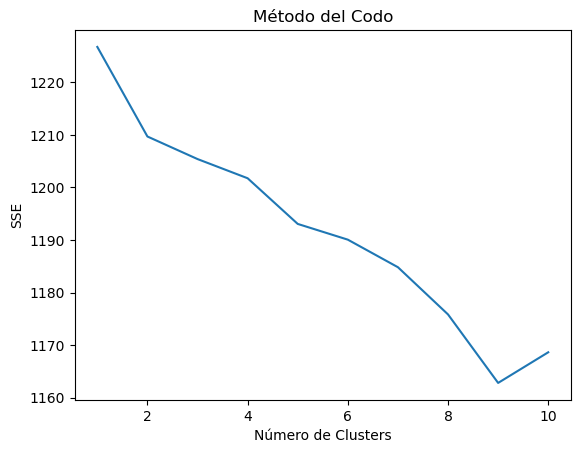

In [47]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings('ignore')


# Calcular el valor de SSE para diferentes valores de k
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(accenture_linkedin_matrix)
    sse.append(kmeans.inertia_)

# Graficar la curva SSE vs. k
plt.plot(range(1, 11), sse)
plt.title('Método del Codo')
plt.xlabel('Número de Clusters')
plt.ylabel('SSE')
plt.show()

In [60]:
# Aplicar el algoritmo K-Means a la matriz de características
kmeans = KMeans(n_clusters=9, random_state=0)
kmeans.fit(accenture_linkedin_matrix)

# Obtener los clusters asignados a cada documento
clusters = kmeans.labels_

# Obtener las palabras más comunes de cada cluster
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names_out()
for i in range(9):
    print("Cluster %d:" % i),
    for j in order_centroids[i, :5]:
        print(' %s' % terms[j]),
    print('\n')

Cluster 0:
 manner
 basic
 boss
 functional
 devop


Cluster 1:
 par
 inference
 intend
 entail
 prompt


Cluster 2:
 ide
 basic
 easyaws
 boss
 explode


Cluster 3:
 predictive
 basic
 entail
 cohesive
 delve


Cluster 4:
 intend
 prospect
 certain
 globerglobant
 pathhow


Cluster 5:
 adequately
 dare
 convergeas
 dataled
 datapeoples


Cluster 6:
 certain
 limit
 hygiene
 basic
 confidence


Cluster 7:
 monitoringthe
 football
 maybe
 clickless
 chance


Cluster 8:
 accelerate
 38
 detailed
 mlt3medium
 daily




Cluster 0: Este cluster parece estar relacionado con la tecnología, específicamente con la gestión de proyectos y el desarrollo de software.

Cluster 1: Este cluster está relacionado con el procesamiento del lenguaje natural y la inferencia.

Cluster 2: Este cluster podría estar relacionado con el desarrollo de software, específicamente con el uso de herramientas y tecnologías como IDE y EasyAWS.

Cluster 3: Este cluster parece estar relacionado con la ciencia de datos y la estadística, específicamente con el modelado predictivo y la exploración de datos.

Cluster 4: Este cluster podría estar relacionado con el análisis de negocios y la planificación estratégica.

Cluster 5: Este cluster parece estar relacionado con la ciencia de datos y el análisis, específicamente con la interpretación y el procesamiento de datos.

Cluster 6: Este cluster está relacionado con la gestión de proyectos y el control de calidad.

Cluster 7: Este cluster parece estar relacionado con el análisis de datos, específicamente con la monitorización y el seguimiento de datos.

Cluster 8: Este cluster podría estar relacionado con la tecnología y el desarrollo, específicamente con la aceleración del proceso de desarrollo y la optimización del rendimiento.


## Globant LinkedIn English

In [21]:
globant_linkedin = main_token("accenture_linkedin.json","content")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ynino\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [50]:
from sklearn.feature_extraction.text import TfidfVectorizer

#Ignore terms that appear in more than 50% of the documents (max_df=0.5) and terms that are not present in at least 5 documents (min_df=5)
vectorizer = TfidfVectorizer(stop_words="english", max_df=0.5, min_df=1, sublinear_tf=True)


globant_linkedin_matrix = vectorizer.fit_transform(globant_linkedin)

print(f"n_samples: {globant_linkedin_matrix.shape[0]}, n_features: {globant_linkedin_matrix.shape[1]}")

n_samples: 1247, n_features: 3140


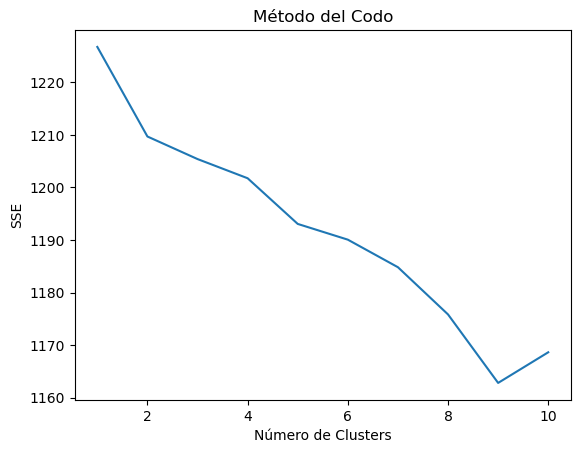

In [51]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings('ignore')


# Calcular el valor de SSE para diferentes valores de k
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(globant_linkedin_matrix)
    sse.append(kmeans.inertia_)

# Graficar la curva SSE vs. k
plt.plot(range(1, 11), sse)
plt.title('Método del Codo')
plt.xlabel('Número de Clusters')
plt.ylabel('SSE')
plt.show()

In [53]:
# Aplicar el algoritmo K-Means a la matriz de características
kmeans = KMeans(n_clusters=9, random_state=0)
kmeans.fit(globant_linkedin_matrix)

# Obtener los clusters asignados a cada documento
clusters = kmeans.labels_

# Obtener las palabras más comunes de cada cluster
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names_out()
for i in range(9):
    print("Cluster %d:" % i),
    for j in order_centroids[i, :5]:
        print(' %s' % terms[j]),
    print('\n')

Cluster 0:
 report
 business
 change
 learn
 fabric


Cluster 1:
 technology
 organization
 people
 help
 work


Cluster 2:
 new
 business
 future
 change
 industry


Cluster 3:
 value
 business
 help
 create
 every_direction


Cluster 4:
 people
 world
 company
 make
 thank


Cluster 5:
 add_value
 embrace_change
 discover_opportunity
 endtoendless
 energized


Cluster 6:
 company
 read
 need
 business
 deliver


Cluster 7:
 share_unleash
 key_tenet
 reveal_4
 continuum_competitor
 competitiveness


Cluster 8:
 _value
 360
 experience_build
 see_potential
 elevate_evolve




Cluster 0: Este cluster parece estar relacionado con el mundo de los negocios y la gestión del cambio y aprendizaje dentro de una organización.

Cluster 1: Este cluster está relacionado con la tecnología y la organización del trabajo y las personas dentro de una empresa.

Cluster 2: Este cluster podría estar relacionado con el futuro de los negocios y los cambios que se esperan en la industria.

Cluster 3: Este cluster parece estar relacionado con la creación de valor en los negocios y cómo las empresas pueden ayudar a sus clientes.

Cluster 4: Este cluster está relacionado con las personas y su papel en las empresas y en el mundo en general.

Cluster 5: Este cluster parece estar relacionado con la creación de valor y las oportunidades que se presentan a las empresas que se adaptan al cambio.

Cluster 6: Este cluster está relacionado con las empresas y sus necesidades, especialmente en lo que respecta a la entrega de productos o servicios.

Cluster 7: Este cluster parece estar relacionado con la competitividad de las empresas y cómo pueden mejorar su posición en el mercado.

Cluster 8: Este cluster está relacionado con la creación de valor y la mejora de la experiencia del usuario en las empresas.


## Accenture Articles

In [34]:
from tokenization import main_token
accenture_articles = main_token("AIAccentureArticles.csv", "Article text")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ynino\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [54]:
from sklearn.feature_extraction.text import TfidfVectorizer

#Ignore terms that appear in more than 50% of the documents (max_df=0.5) and terms that are not present in at least 5 documents (min_df=5)
vectorizer = TfidfVectorizer(stop_words="english", max_df=0.5, min_df=1, sublinear_tf=True)


accenture_articles_matrix = vectorizer.fit_transform(accenture_articles)

print(f"n_samples: {accenture_articles_matrix.shape[0]}, n_features: {accenture_articles_matrix.shape[1]}")

n_samples: 12, n_features: 1797


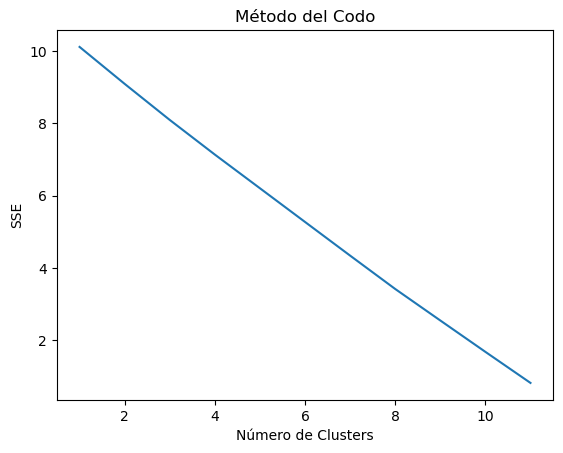

In [55]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings('ignore')


# Calcular el valor de SSE para diferentes valores de k
sse = []
for k in range(1, 12):
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(accenture_articles_matrix)
    sse.append(kmeans.inertia_)

# Graficar la curva SSE vs. k
plt.plot(range(1, 12), sse)
plt.title('Método del Codo')
plt.xlabel('Número de Clusters')
plt.ylabel('SSE')
plt.show()

In [61]:
# Aplicar el algoritmo K-Means a la matriz de características
kmeans = KMeans(n_clusters=9, random_state=0)
kmeans.fit(accenture_articles_matrix)

# Obtener los clusters asignados a cada documento
clusters = kmeans.labels_

# Obtener las palabras más comunes de cada cluster
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names_out()
for i in range(9):
    print("Cluster %d:" % i),
    for j in order_centroids[i, :5]:
        print(' %s' % terms[j]),
    print('\n')

Cluster 0:
 acceptance
 dig
 accompany
 communicate
 accept


Cluster 1:
 defective
 buildklout
 expert
 croatia
 box


Cluster 2:
 aiai
 fluency
 blank
 group
 3d


Cluster 3:
 bard
 addition
 glober
 findai
 astonishing


Cluster 4:
 appif
 famous
 effectively
 gigabyte
 casesfuturescape


Cluster 5:
 datapeoples
 distribution
 functionalitieswhat
 fabrication
 augoorthis


Cluster 6:
 augment_coding
 biotech
 conclusion
 categorical
 feedwho


Cluster 7:
 control
 dare
 guide
 assetdata
 connection


Cluster 8:
 audiencemany
 commit
 domainspick
 exact
 device




Cluster 0: Este cluster parece estar relacionado con la comunicación y la aceptación en un contexto social o interpersonal.

Cluster 1: Este cluster podría estar relacionado con temas de tecnología y negocios, con palabras como "defective", "buildklout" y "box".

Cluster 2: Este cluster está relacionado con temas tecnológicos y parece contener palabras relacionadas con la inteligencia artificial y la visualización en 3D.

Cluster 3: Este cluster parece estar relacionado con temas tecnológicos avanzados, como la IA y el procesamiento de lenguaje natural.

Cluster 4: Este cluster parece estar relacionado con la tecnología y cómo se utiliza para abordar diferentes casos de uso.

Cluster 5: Este cluster está relacionado con la tecnología y parece estar enfocado en la distribución de datos y la fabricación.

Cluster 6: Este cluster está relacionado con la tecnología y parece estar enfocado en la programación y la biotecnología.

Cluster 7: Este cluster está relacionado con la tecnología y podría estar relacionado con temas como el control de datos y la seguridad.

Cluster 8: Este cluster podría estar relacionado con temas de tecnología y negocios, con palabras como "audiencia", "commit" y "domainspick".



## Globant Articles

In [30]:
from tokenization import main_token
globant_articles = main_token("AIGlobantArticles.csv", "Article text")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ynino\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [57]:
from sklearn.feature_extraction.text import TfidfVectorizer

#Ignore terms that appear in more than 50% of the documents (max_df=0.5) and terms that are not present in at least 5 documents (min_df=5)
vectorizer = TfidfVectorizer(stop_words="english", max_df=0.5, min_df=1, sublinear_tf=True)


globant_articles_matrix = vectorizer.fit_transform(globant_articles)

print(f"n_samples: {globant_articles_matrix.shape[0]}, n_features: {globant_articles_matrix.shape[1]}")

n_samples: 39, n_features: 4374


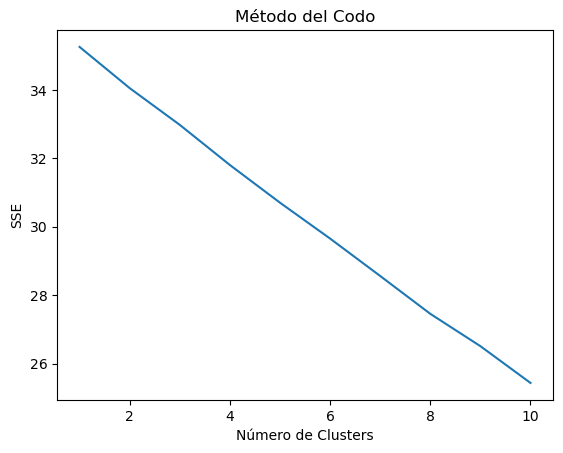

In [58]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings('ignore')


# Calcular el valor de SSE para diferentes valores de k
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(globant_articles_matrix)
    sse.append(kmeans.inertia_)

# Graficar la curva SSE vs. k
plt.plot(range(1, 11), sse)
plt.title('Método del Codo')
plt.xlabel('Número de Clusters')
plt.ylabel('SSE')
plt.show()

In [59]:
# Aplicar el algoritmo K-Means a la matriz de características
kmeans = KMeans(n_clusters=8, random_state=0)
kmeans.fit(globant_articles_matrix)

# Obtener los clusters asignados a cada documento
clusters = kmeans.labels_

# Obtener las palabras más comunes de cada cluster
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names_out()
for i in range(8):
    print("Cluster %d:" % i),
    for j in order_centroids[i, :5]:
        print(' %s' % terms[j]),
    print('\n')

Cluster 0:
 code
 augment_code
 natural_language
 developer
 tool


Cluster 1:
 brand
 customer
 user
 voice
 content


Cluster 2:
 globot
 world_cup
 game
 statistical
 glober


Cluster 3:
 explainable
 speaker
 mlops
 mlop
 government


Cluster 4:
 drug
 molecule
 compound
 screening
 streamline


Cluster 5:
 code
 table
 software
 configuration
 genexus


Cluster 6:
 supply_chain
 scm
 forecasting
 autonomous
 optimization


Cluster 7:
 think
 consider
 drive
 insight
 outcome




Cluster 0: Este cluster está relacionado con la programación y el desarrollo de herramientas y lenguajes de programación, como el código, el desarrollo de herramientas y la creación de lenguajes naturales.

Cluster 1: Este cluster está relacionado con temas de marketing y negocios, como la marca, el usuario, la voz del cliente y el contenido.

Cluster 2: Este cluster está relacionado con eventos deportivos globales, como la Copa del Mundo, y podría estar relacionado con temas estadísticos.

Cluster 3: Este cluster está relacionado con temas de inteligencia artificial y gobierno, con palabras como "explainable", "mlops" y "government".

Cluster 4: Este cluster está relacionado con temas de ciencias de la vida, como la investigación de drogas y moléculas, y podría estar relacionado con la optimización de los procesos de investigación.

Cluster 5: Este cluster está relacionado con la programación y el desarrollo de software, con palabras como "código", "tabla" y "configuración".

Cluster 6: Este cluster está relacionado con la gestión de la cadena de suministro y la optimización, con palabras como "autónomo", "optimización" y "previsión".

Cluster 7: Este cluster está relacionado con la toma de decisiones y la generación de conocimiento, con palabras como "pensar", "considerar" y "resultados".
